# Time Series Analysis and Univariate ARIMA Models

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os
import sys
import warnings
from datetime import date
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import quandl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [22]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [15]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

### Log Transformation

In [16]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

In [17]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


Chapter 8 introduces the ARIMA building blocks, simple autoregressive (AR) and moving average (MA) models, and explains how to combine them in autoregressive moving-average (ARMA) models that may account for series integration as ARIMA models or include exogenous variables as AR(I)MAX models. 

Furthermore, we will illustrate how to include seasonal AR and MA terms to extend the toolbox to also include SARMAX models.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [13]:
model1 = tsa.ARMA(endog=nasdaq_log_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

In [14]:
model1.params.sort_index() == model2.params.sort_index().values

ar.L1.NASDAQCOM    True
ar.L2.NASDAQCOM    True
const              True
ma.L1.NASDAQCOM    True
ma.L2.NASDAQCOM    True
dtype: bool

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order (0,1,0,12).

In [15]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [16]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.761975,1.765978
ar.L2,-0.784199,-0.788255
ma.L1,-0.841204,-0.859608
ma.L2,0.313330,0.353158
sigma2,0.000101,0.000101


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

In [17]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [18]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.2 KB


In [19]:
with pd.HDFStore('results/arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [20]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
3 3  0.009770 -759.454738 -737.154804          2.0          16.0
4 1  0.010033 -759.089418 -739.576976          0.0           2.0
  0  0.010149 -758.145499 -741.420548          0.0           0.0
3 0  0.010585 -747.347746 -733.410287          0.0           0.0
1 0  0.011551 -727.389093 -719.026618          0.0           0.0

In [27]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
2 2  0.012664 -758.359534 -741.634584          0.0           4.0
4 0  0.010149 -758.145499 -741.420548          0.0           0.0
  1  0.010033 -759.089418 -739.576976          0.0           2.0
3 1  0.011752 -754.413970 -737.689020          1.0           5.0
  4  0.043134 -762.622279 -737.534853          2.0          57.0

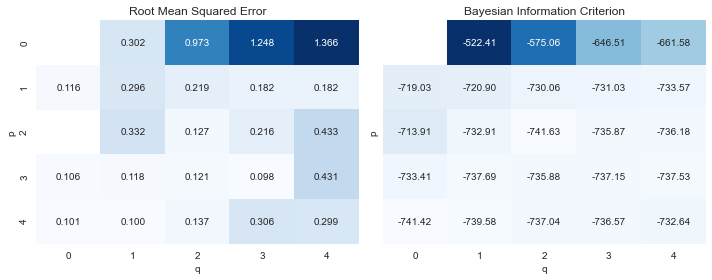

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [28]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
4  0    2.5
   1    2.5
3  3    3.5
2  2    4.5
3  1    5.0
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [24]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [25]:
best_arma_model = tsa.ARMA(endog=industrial_production_log_diff, order=(best_p, best_q)).fit()
print(best_arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                     ARMA(4, 0)   Log Likelihood                1106.892
Method:                       css-mle   S.D. of innovations              0.010
Date:                Thu, 16 Apr 2020   AIC                          -2201.783
Time:                        18:25:55   BIC                          -2178.670
Sample:                    01-01-1989   HQIC                         -2192.581
                         - 12-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0205      0.009      2.222      0.026       0.002       0.039
ar.L1.IPGMFN     0.9252      0.051     18.260      0.000       0.826       1.025
ar.L2.IPGMFN     0.3341      0.071      4.70

### Check Residual Correlogram

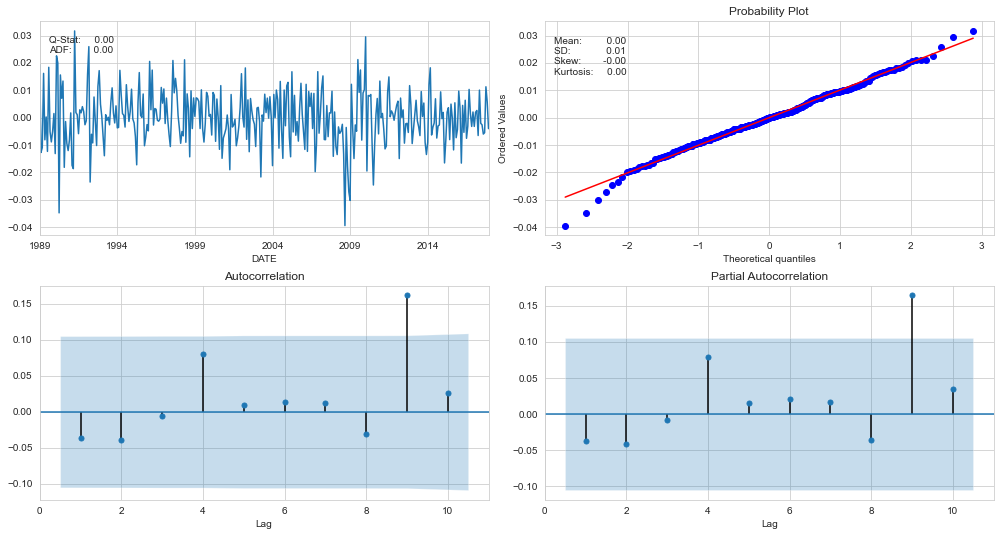

In [26]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [29]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna(),
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1128.408
Date:                              Thu, 16 Apr 2020   AIC                          -2242.816
Time:                                      18:27:05   BIC                          -2215.851
Sample:                                  01-01-1989   HQIC                         -2232.081
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1367      0.494      0.277      0.782      -0.831       1.105
ar.L2          0.84

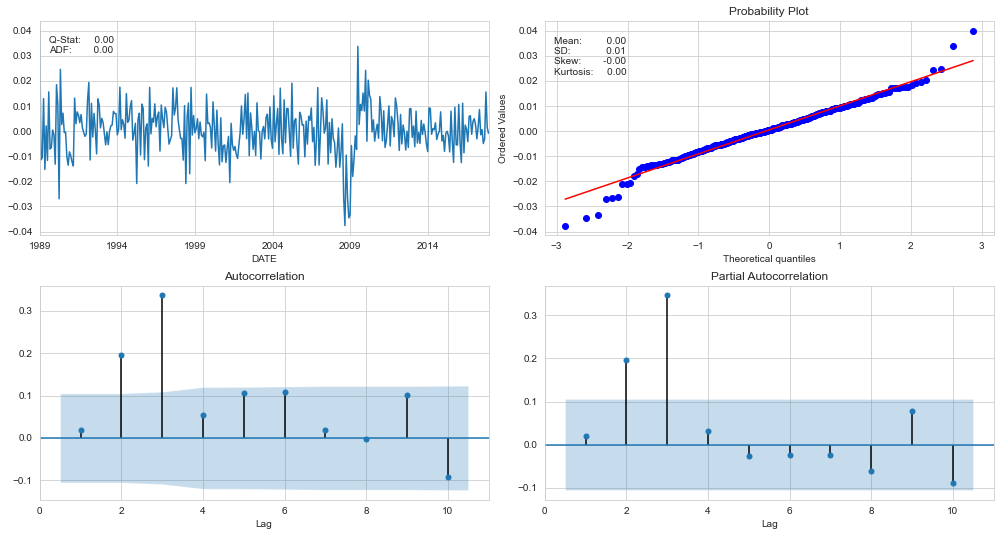

In [30]:
plot_correlogram(sarimax_model.resid)

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

In [ ]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
                aic, bic = [], []
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
                    train_set = industrial_production_log_diff.iloc[T-train_size:T]
                    try:
                        model = tsa.SARIMAX(endog=train_set,
                                            order=(p1, 0, q1),
                                            seasonal_order=(p2, 0, q2, 12)).fit()
                    except LinAlgError:
                        convergence_error += 1
                    except ValueError:
                        stationarity_error += 1

                    preds.iloc[i, 1] = model.forecast(steps=1)[0]
                    aic.append(model.aic)
                    bic.append(model.bic)
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(preds.y_true, preds.y_pred)
                results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  preds.y_true.sub(preds.y_pred).std(),
                                                  np.mean(aic),
                                                  np.std(aic),                                                  
                                                  np.mean(bic),
                                                  np.std(bic),                                                  
                                                  convergence_error,
                                                  stationarity_error]

### Compare model metrics

In [ ]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(df.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

In [ ]:
with pd.HDFStore('results/arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [6]:
with pd.HDFStore('results/arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [7]:
sarimax_results.nsmallest(5, columns='RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  3  1  0   0.009323  0.009335 -772.247023  20.106627 -752.734581  20.106627   
3  2  1  0   0.009467  0.009486 -768.844028  17.479101 -749.331586  17.479101   
2  2  1  0   0.009540  0.009559 -770.904835  17.162805 -754.179884  17.162805   
   3  0  0   0.009773  0.009790 -760.248885  23.627233 -743.523935  23.627233   
   2  0  0   0.009986  0.010005 -758.775827  20.636387 -744.838368  20.636387   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  3  1  0           2.0           1.0  1.001263  
3  2  1  0           1.0           1.0  1.001913  
2  2  1  0           0.0           2.0  1.002046  
   3  0  0           0.0           1.0  1.001768  
   2  0  0           0.0           2.0  1.001922

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [10]:
print(sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head())

                 RMSE         AIC         BIC
p1 q1 p2 q2                                  
2  3  1  0   0.009323 -772.247023 -752.734581
3  2  1  0   0.009467 -768.844028 -749.331586
2  2  1  0   0.009540 -770.904835 -754.179884
   3  0  0   0.009773 -760.248885 -743.523935
   2  0  0   0.009986 -758.775827 -744.838368


In [11]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.368545,0.417667
AIC,0.368545,1.000000,0.940401
BIC,0.417667,0.940401,1.000000


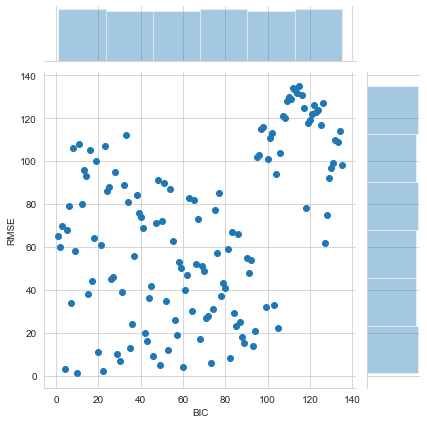

In [12]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [13]:
sarimax_results[(sarimax_results.RMSE<sarimax_results.RMSE.quantile(.05))&
                (sarimax_results.BIC<sarimax_results.BIC.quantile(.1))]

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  2  1  0   0.009540  0.009559 -770.904835  17.162805 -754.179884  17.162805   
   3  1  0   0.009323  0.009335 -772.247023  20.106627 -752.734581  20.106627   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  2  1  0           0.0           2.0  1.002046  
   3  1  0           2.0           1.0  1.001263

### Train best model

In [26]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff, order=(2, 0, 3),
                         seasonal_order=(1, 0, 0, 12)).fit()
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 3)x(1, 0, [], 12)   Log Likelihood                1139.555
Date:                             Thu, 16 Apr 2020   AIC                          -2265.110
Time:                                     21:31:47   BIC                          -2238.144
Sample:                                 01-01-1989   HQIC                         -2254.374
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5046      0.108     13.955      0.000       1.293       1.716
ar.L2         -0.5271      

### Check Residual Correlogram

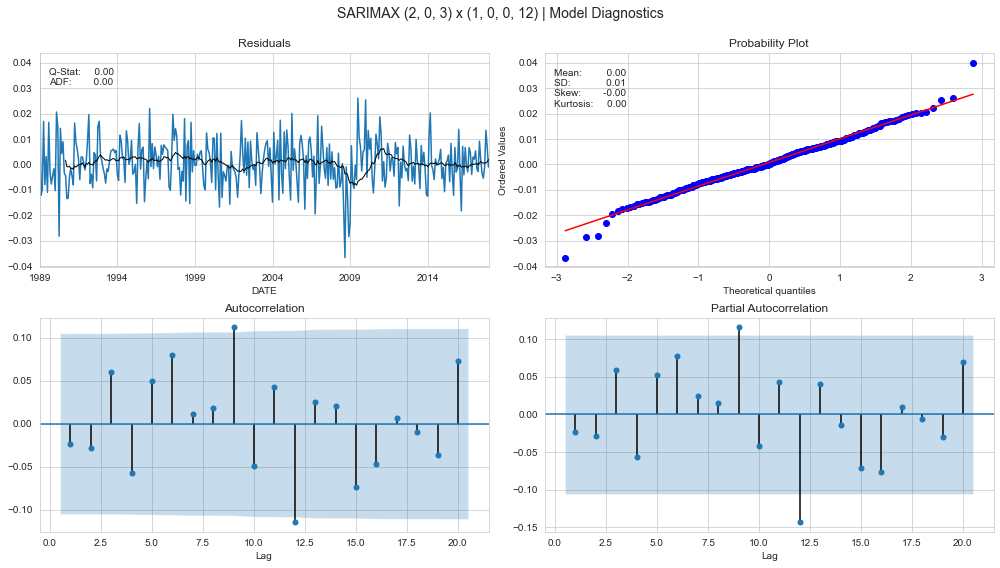

In [27]:
plot_correlogram(best_model.resid, lags=20, title='SARIMAX (2, 0, 3) x (1, 0, 0, 12) | Model Diagnostics')